# self-attention

## setup

In [358]:
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [359]:
EMBED_SIZE = 8
VOCAB_SIZE = 11
HIDDEN_SIZE = 32
CONTEXT_SIZE = 10
MAGIC_TOKEN = VOCAB_SIZE-1
EPOCHS = 10000
LEARNING_RATE = 3e-4

In [360]:
X = []
Y = []

for i in range(1000):
  magic_token_idx = random.randint(1, CONTEXT_SIZE/2 -1)
  x = [random.randint(1,VOCAB_SIZE-2) for _ in range(magic_token_idx)] + [MAGIC_TOKEN] + [0 for _ in range(CONTEXT_SIZE - magic_token_idx - 1)]
  y = x[:magic_token_idx+1] + x[:magic_token_idx] + [0 for _ in range(CONTEXT_SIZE - 2 * magic_token_idx - 1)]
  X.append(x)
  Y.append(y)

X = torch.tensor(X).to(device)
Y= torch.tensor(Y).to(device)

## code

In [361]:
def get_training():
  X = torch.tensor([[0, 1, 2, 3],
                    [3, 2, 1, 0]])

  X = torch.randint(0, VOCAB_SIZE-2, (1000, CONTEXT_SIZE))

  Y = torch.ones_like(X) # TODO
  return X.to(device), Y.to(device)

In [362]:
activations = {}

class Attention(nn.Module):
  def __init__(self):
    super().__init__()
    self.w_key = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.w_query = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.w_value = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.ln = nn.LayerNorm(EMBED_SIZE)

  def forward(self, x):
    # generate K,Q,V
    key = self.w_key(x)
    query = self.w_query(x)
    value = self.w_value(x)
    # pre-layernorm
    # x = self.ln(x)
    # do the attention
    correlation = query @ key.transpose(-2, -1)
    correlation = correlation / math.sqrt(key.shape[-1])
    correlation = F.softmax(correlation, dim=-1)
    activations['x'] = correlation.detach()
    new_embedding = correlation @ value
    # post-layernorm
    new_embedding = self.ln(new_embedding)
    return new_embedding

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding = nn.Embedding(VOCAB_SIZE, EMBED_SIZE)
    self.positional_embedding = nn.Embedding(CONTEXT_SIZE, EMBED_SIZE)
    self.attention = Attention()
    self.ff = nn.Sequential(
      nn.Linear(EMBED_SIZE, HIDDEN_SIZE),
      nn.ReLU(),
      nn.Linear(HIDDEN_SIZE, EMBED_SIZE),
      nn.LayerNorm(EMBED_SIZE),
    )
    self.head = nn.Linear(EMBED_SIZE, VOCAB_SIZE)

  def forward(self, x):
    # (batch_size, context_size)
    x = self.token_embedding(x)  # (batch_size, context_size, embedding_size)
    # positional encoding
    x = x + self.positional_embedding(torch.arange(0, x.shape[1]).to(device))
    # attention
    x = x + self.attention(x)
    # feed forward
    x = x + self.ff(x)
    # head
    x = self.head(x)
    return x

In [363]:
model = Net().to(device)

In [370]:
def train(model, epochs=EPOCHS, lr=LEARNING_RATE):
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    out = model(X)
    loss = F.cross_entropy(out.view(-1, out.shape[-1]), Y.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 50000 == 0:
      print(f'{epoch:5} {loss.item()}')

train(model, epochs=500000, lr=3e-4)

    0 0.007539726328104734
50000 0.0008970893686637282
100000 0.0003907835343852639
150000 7.376769644906744e-05
200000 0.0001236584212165326
250000 6.731127086823108e-06
300000 5.363372474675998e-05
350000 8.474625246890355e-06
400000 2.9927092327852733e-05
450000 5.174201191948669e-07


In [371]:
res = model(X).argmax(-1)
correct = ((res == Y).float().sum(-1) == CONTEXT_SIZE).float().sum()
print(f'accuracy: {correct / len(X)}')
res[:20]

accuracy: 1.0


tensor([[ 4, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  2,  6, 10,  2,  2,  6,  0,  0,  0],
        [ 6, 10,  6,  0,  0,  0,  0,  0,  0,  0],
        [ 4,  8, 10,  4,  8,  0,  0,  0,  0,  0],
        [ 1,  5,  6, 10,  1,  5,  6,  0,  0,  0],
        [ 5,  2,  7,  4, 10,  5,  2,  7,  4,  0],
        [ 2,  7,  2,  3, 10,  2,  7,  2,  3,  0],
        [ 4,  4,  7, 10,  4,  4,  7,  0,  0,  0],
        [ 4,  4,  4, 10,  4,  4,  4,  0,  0,  0],
        [ 1,  9,  6,  3, 10,  1,  9,  6,  3,  0],
        [ 7, 10,  7,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  5, 10,  3,  5,  0,  0,  0,  0,  0],
        [ 1,  9,  5,  8, 10,  1,  9,  5,  8,  0],
        [ 4, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 5,  4, 10,  5,  4,  0,  0,  0,  0,  0],
        [ 7, 10,  7,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  5, 10,  2,  5,  0,  0,  0,  0,  0],
        [ 5,  1, 10,  5,  1,  0,  0,  0,  0,  0],
        [ 1, 10,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 9, 10,  9,  0,  0,  0,  0,  0,  0,  0]],

tensor([[ 7,  1,  9,  2, 10,  7,  1,  9,  2,  0]], device='cuda:0')


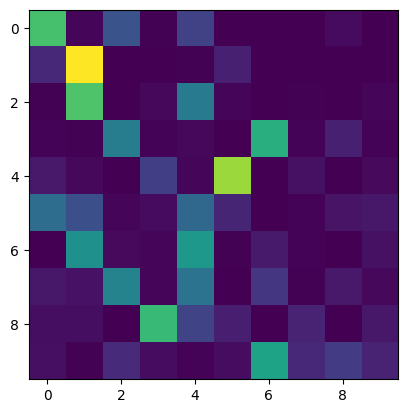

In [376]:
res = model(torch.tensor([[7,1,9,2,10,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[1,2,10,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,10,0,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,3,4,10,0,0,0,0,0,0]]).to(device)).argmax(-1)
print(res)

_ = plt.imshow(activations['x'].squeeze().cpu())

In [378]:
# save
# ----
# torch.save(model.state_dict(), 'weights/copy-task-500k-epochs.pt')

# load
# ----
# m = Net().to(device)
# m.load_state_dict(torch.load('weights/copy-task-500k-epochs.pt'))

<All keys matched successfully>

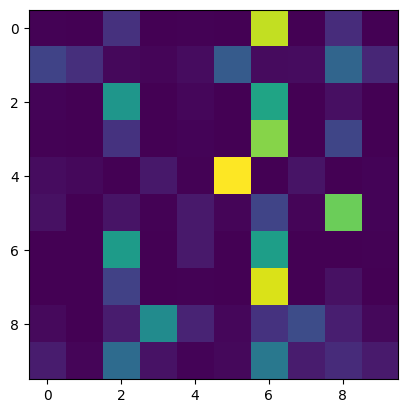

In [382]:
m(torch.tensor([[8,8,8,8,10,8,8,8,8,0]], device=device)).argmax(-1).tolist()[:10]
_ = plt.imshow(activations['x'].squeeze().cpu())